In [ ]:
# Import library yang diperlukan
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [ ]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


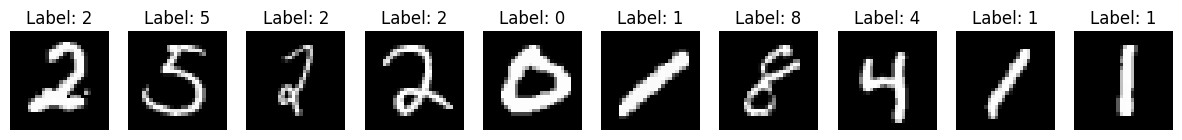

In [ ]:
# Transformasi data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalisasi untuk MNIST
])

# Load dataset MNIST langsung dari torchvision
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Fungsi untuk menampilkan beberapa gambar dari dataset
def show_sample_images(loader, num_images=10):
    images, labels = next(iter(loader))  # Ambil satu batch data
    images, labels = images[:num_images], labels[:num_images]  # Pilih sejumlah gambar pertama

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(images[i].squeeze(), cmap="gray")
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis("off")
    plt.show()

# Tampilkan beberapa gambar dari dataset
show_sample_images(train_loader)

In [ ]:
# Definisikan BasicBlock untuk ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                              padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                              padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [ ]:
# Definisikan ResNet-18
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
# Transformasi data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalisasi untuk MNIST
])

In [ ]:
# Load dataset MNIST langsung dari torchvision
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Inisialisasi model ResNet-18
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Fungsi pelatihan
def train_model(model, train_loader, test_loader, epochs=10):
    train_losses = []
    train_accs = []
    val_losses = []  # Tambahkan list untuk menyimpan validation loss
    val_accs = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validasi
        model.eval()
        val_running_loss = 0.0  # Tambahkan ini untuk menghitung validation loss
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)  # Hitung validation loss
                val_running_loss += loss.item()  # Akumulasi loss

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(test_loader)  # Rata-rata validation loss
        val_acc = 100 * correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)  # Simpan validation loss
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, val_losses, train_accs, val_accs

In [ ]:
# Latih model
epochs = 10
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, test_loader, epochs)

Epoch 1: Train Loss: 0.0024, Train Acc: 99.92%, Val Loss: 0.0221, Val Acc: 99.47%
Epoch 2: Train Loss: 0.0015, Train Acc: 99.96%, Val Loss: 0.0252, Val Acc: 99.38%
Epoch 3: Train Loss: 0.0026, Train Acc: 99.93%, Val Loss: 0.0277, Val Acc: 99.43%
Epoch 4: Train Loss: 0.0018, Train Acc: 99.94%, Val Loss: 0.0241, Val Acc: 99.48%
Epoch 5: Train Loss: 0.0011, Train Acc: 99.97%, Val Loss: 0.0373, Val Acc: 99.25%
Epoch 6: Train Loss: 0.0029, Train Acc: 99.91%, Val Loss: 0.0273, Val Acc: 99.43%
Epoch 7: Train Loss: 0.0027, Train Acc: 99.93%, Val Loss: 0.0256, Val Acc: 99.48%
Epoch 8: Train Loss: 0.0015, Train Acc: 99.95%, Val Loss: 0.0246, Val Acc: 99.43%
Epoch 9: Train Loss: 0.0013, Train Acc: 99.96%, Val Loss: 0.0240, Val Acc: 99.44%
Epoch 10: Train Loss: 0.0022, Train Acc: 99.93%, Val Loss: 0.0361, Val Acc: 99.28%


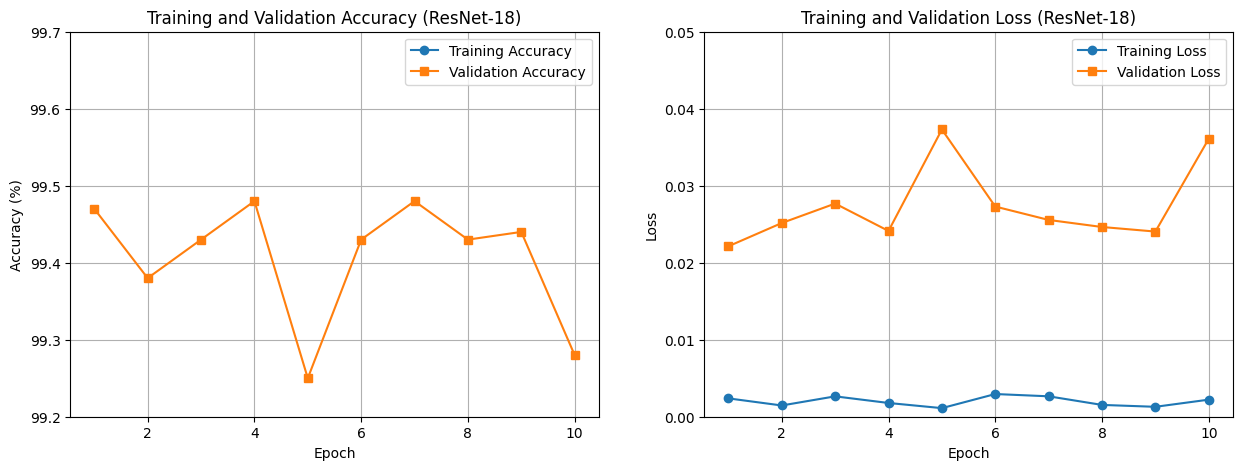

In [ ]:
import matplotlib.pyplot as plt

# Plot grafik akurasi dan loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Accuracy
axes[0].plot(range(1, epochs+1), train_accs, label='Training Accuracy', marker='o')
axes[0].plot(range(1, epochs+1), val_accs, label='Validation Accuracy', marker='s')
axes[0].set_title('Training and Validation Accuracy (ResNet-18)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_ylim(99.2, 99.7)  # Rentang diperlebar agar tren naik terlihat
axes[0].legend()
axes[0].grid(True)

# Plot Loss
axes[1].plot(range(1, epochs+1), train_losses, label='Training Loss', marker='o')
axes[1].plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='s')
axes[1].set_title('Training and Validation Loss (ResNet-18)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_ylim(0, 0.05)  # Sesuai dengan nilai loss yang kecil
axes[1].legend()
axes[1].grid(True)

plt.show()

In [ ]:
# Tampilkan arsitektur CNN dalam tabel
def print_model_architecture(model):
    architecture = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.BatchNorm2d, nn.ReLU,
                             nn.AdaptiveAvgPool2d, nn.Linear)):
            if isinstance(module, nn.Conv2d):
                params = f"in={module.in_channels}, out={module.out_channels}, " \
                        f"kernel={module.kernel_size}, stride={module.stride}"
            elif isinstance(module, nn.BatchNorm2d):
                params = f"features={module.num_features}"
            elif isinstance(module, nn.Linear):
                params = f"in={module.in_features}, out={module.out_features}"
            else:
                params = "-"
            architecture.append([name, module.__class__.__name__, params])

    df = pd.DataFrame(architecture, columns=['Layer Name', 'Layer Type', 'Parameters'])
    return df

In [ ]:
# Tampilkan tabel arsitektur
arch_table = print_model_architecture(model)
print("\nArsitektur ResNet-18:")
print(arch_table.to_string(index=False))

In [ ]:
# Kesimpulan
print("\nKesimpulan:")
print(f"1. Model ResNet-18 berhasil dilatih selama {epochs} epoch.")
print(f"2. Akurasi pelatihan tertinggi: {max(train_accs):.2f}%")
print(f"3. Akurasi validasi tertinggi: {max(val_accs):.2f}%")
print("4. ResNet-18 menunjukkan performa yang sangat baik pada dataset MNIST, "
      "dengan konvergensi cepat berkat residual connections.")